In [5]:
#Importing necessary libraries for the project
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr


In [6]:
from google.colab import files
uploaded = files.upload()  # Upload your dataset zip (e.g., trash_dataset.zip)


Saving archive (3).zip to archive (3).zip


In [7]:
!unzip archive\ \(3\).zip -d dataset/


Archive:  archive (3).zip
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_001.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_002.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_003.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_004.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_005.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_006.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_007.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_008.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_009.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_010.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_011.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_012.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_013.jpg  

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",   # ✅ updated path
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",   # ✅ updated path
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [9]:
val_class=val_ds.class_names
print(val_class)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
val_batches=tf.data.experimental.cardinality(val_ds)
print(val_batches)



tf.Tensor(16, shape=(), dtype=int64)


In [11]:
test_ds=val_ds.take(val_batches //2)
val_dat=val_ds.skip(val_batches //2)
test_ds_eval=test_ds.cache().prefetch(tf.data.AUTOTUNE)
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


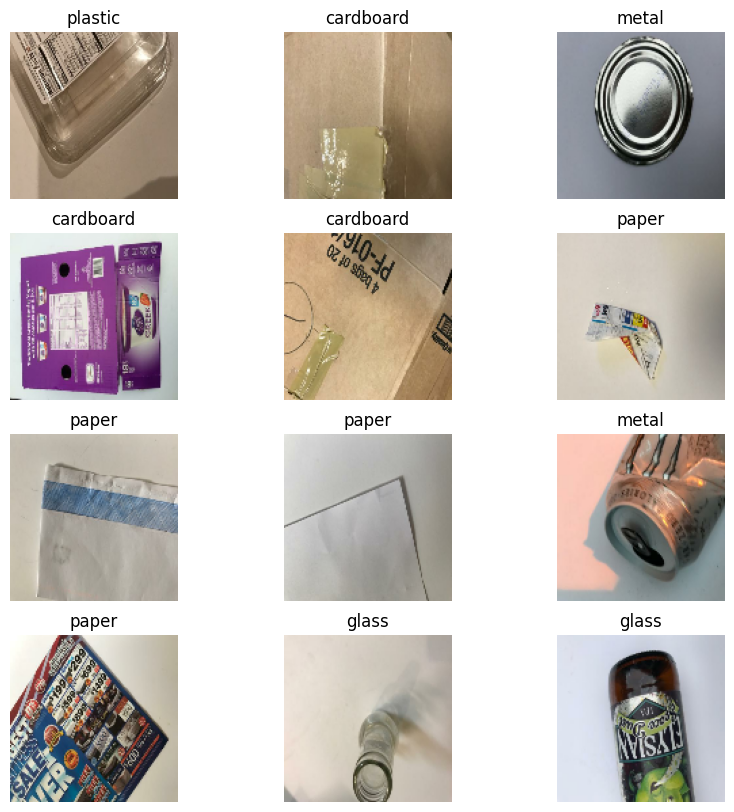

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [13]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [14]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [15]:
# Ensure datasets are defined
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

# Recalculate val_batches and test_ds after re-creating val_ds
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds_split = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

class_names=train_ds.class_names
train_dist=count_distribution(train_ds,class_names)
val_dist=count_distribution(val_ds,class_names)
test_dist = count_distribution(test_ds_split, class_names)

overall_dist={}
for k in class_names:
  overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print("Training Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution:", overall_dist)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Training Distribution: {'cardboard': 15.83, 'glass': 19.68, 'metal': 16.42, 'paper': 23.24, 'plastic': 19.49, 'trash': 5.34}
Validation Distribution: {'cardboard': 16.44, 'glass': 20.4, 'metal': 15.45, 'paper': 24.55, 'plastic': 17.43, 'trash': 5.74}
Test Distribution: {'cardboard': 18.36, 'glass': 21.48, 'metal': 16.02, 'paper': 24.61, 'plastic': 13.28, 'trash': 6.25}
Overall Distribution: {'cardboard': 16.14, 'glass': 20.04, 'metal': 15.94, 'paper': 23.89, 'plastic': 18.46, 'trash': 5.54}


In [16]:
class_counts={i:0 for i in range(len(class_names))}
all_labels=[]
for images,labels in train_ds:
  for label in labels.numpy():
    class_counts[label]+=1
    all_labels.append(label)

class_weights_array=compute_class_weight(class_weight='balanced',classes=np.arange(len(class_names)),y=all_labels)
class_weights={i: w for i,w in enumerate(class_weights_array)}
print(class_counts)
print(class_weights)

{0: 320, 1: 398, 2: 332, 3: 470, 4: 394, 5: 108}
{0: np.float64(1.053125), 1: np.float64(0.8467336683417085), 2: np.float64(1.0150602409638554), 3: np.float64(0.7170212765957447), 4: np.float64(0.8553299492385786), 5: np.float64(3.1203703703703702)}


In [17]:
data_augmentation=Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),])


In [18]:
base_model=EfficientNetV2B2(include_top=False,weights='imagenet',input_shape=(180,180,3),include_preprocessing=False)
base_model.trainable=True
for layer in base_model.layers[:100]:
  layer.trainable=False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model=Sequential([layers.Input(shape=(124,124,3)),data_augmentation,layers.Resizing(180, 180),base_model,GlobalAveragePooling2D(),layers.Dropout(0.2),layers.Dense(len(class_names),activation='softmax')])

In [23]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
epochs=15
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs,class_weight=class_weights,batch_size=32,callbacks=[early])


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.3094 - loss: 1.6176 - val_accuracy: 0.5030 - val_loss: 1.3194
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - accuracy: 0.4727 - loss: 1.3156 - val_accuracy: 0.5683 - val_loss: 1.1556
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 332s 5s/step - accuracy: 0.5539 - loss: 1.1460 - val_accuracy: 0.6257 - val_loss: 1.0712
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.6264 - loss: 1.0133 - val_accuracy: 0.6871 - val_loss: 0.9514
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.6615 - loss: 0.9117 - val_accuracy: 0.7030 - val_loss: 0.8899
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.6528 - loss: 0.8924 - val_accuracy: 0.7188 - val_loss: 0.8134
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 344s 5s/step - accuracy: 0.6969 - loss: 0.7970 - val_accuracy: 0.7327 - val_loss: 0.8034
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.7157 - loss: 0.7586 - val_accuracy: 0.7505 - v

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 6, 6, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [26]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 90, 90,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 90, 90,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 90, 90,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 90, 90,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 90, 90,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 90, 90,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 90, 90,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 90, 90,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 90, 90,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 90, 90,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 90, 90,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 45, 45,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 45, 45,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 45, 45,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 45, 45,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 45, 45,    │        128 │ block2a_project_

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(len(acc))


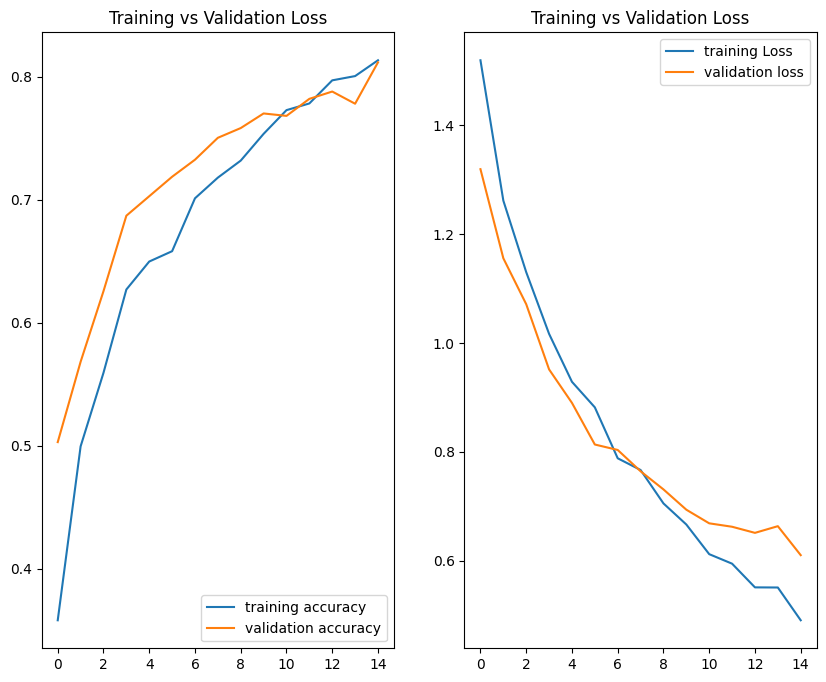

In [28]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='training accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation Loss")

plt.subplot(1,2,2)

plt.plot(epochs_range,loss, label='training Loss')
plt.plot(epochs_range,val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title("Training vs Validation Loss")
plt.show() #display the graphs

In [29]:
loss,accuracy=model.evaluate(test_ds_eval)
print(f'Test Accuracy :{accuracy:.4f}, Test Loss :{loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8232 - loss: 0.5882
Test Accuracy :0.8164, Test Loss :0.6264


In [30]:
# Extract true labels from all batches in the test dataset
y_true=np.concatenate([y.numpy() for x,y in test_ds_eval],axis=0) #Convert Tensor labels to NumPy array and concatenate them
#get predictions as probabilities from the model
y_pred_probs=model.predict(test_ds_eval)#predict class probabilities for each sample in dataset
#convert probabilities to predicted class indices
y_pred=np.argmax(y_pred_probs,axis=1)#select the class with the highest probability for each sample
cm = confusion_matrix(y_true, y_pred)
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step
[[32  1  1  3  2  1]
 [ 0 48  3  0  3  2]
 [ 0  4 33  0  1  1]
 [ 0  1  0 54  2  6]
 [ 1  8  2  2 28  1]
 [ 1  1  0  0  0 14]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        40
           1       0.76      0.86      0.81        56
           2       0.85      0.85      0.85        39
           3       0.92      0.86      0.89        63
           4       0.78      0.67      0.72        42
           5       0.56      0.88      0.68        16

    accuracy                           0.82       256
   macro avg       0.80      0.82      0.80       256
weighted avg       0.83      0.82      0.82       256



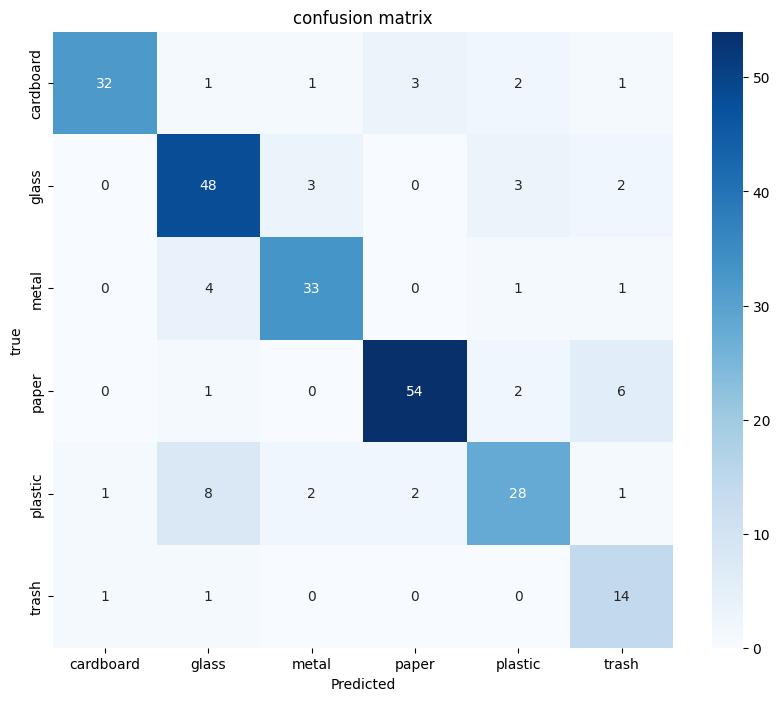

In [31]:
#plotting the confusion matrix to visualize model performance
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('true')
plt.title('confusion matrix')
plt.show() #display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


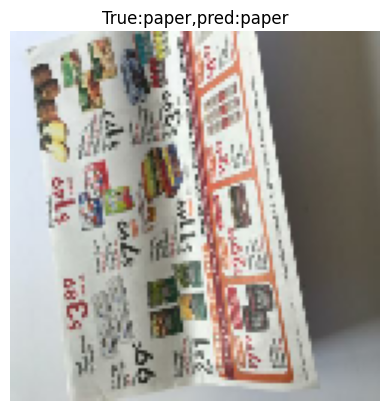

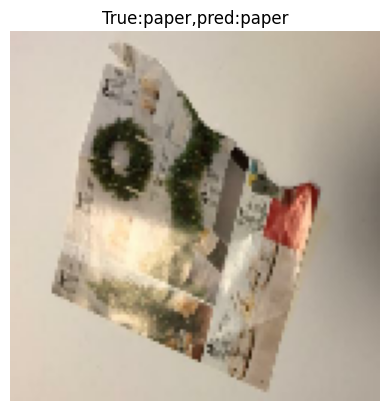

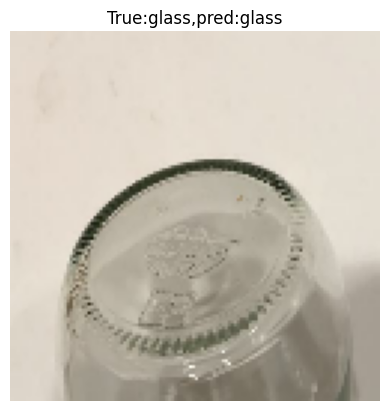

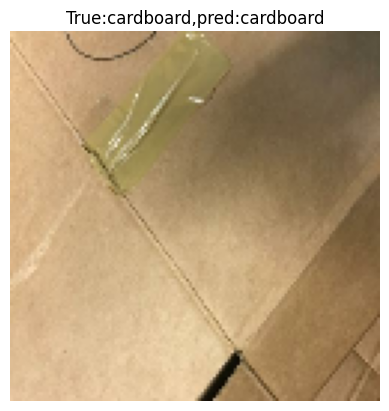

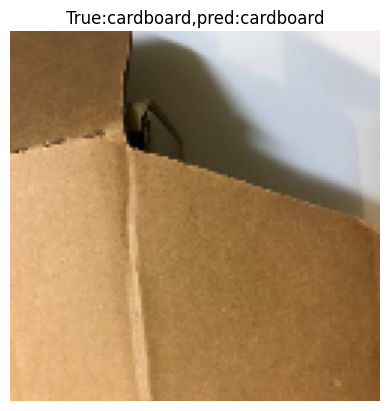

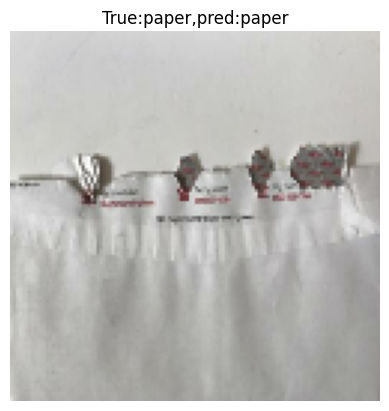

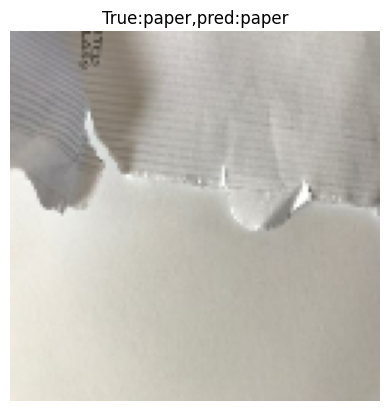

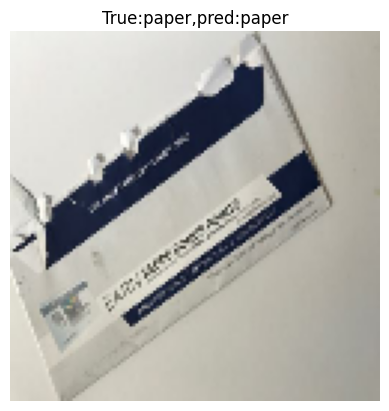

In [33]:
class_names=train_ds.class_names #extract class names
for images,labels in test_ds_eval.take(1):
  predictions=model.predict(images)
  pred_labels=tf.argmax(predictions,axis=1)
  for i in range(8):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"True:{class_names[labels[i]]},pred:{class_names[pred_labels[i]]}")
    plt.axis("off")
    plt.show()

In [34]:
model.save('Effiicientnetv2b2.keras') # saving the model

In [35]:
from google.colab import files
files.download('Effiicientnetv2b2.keras') #downloading the model file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
model = tf.keras.models.load_model('Effiicientnetv2b2.keras') #load the model

In [37]:
print(accuracy)

0.81640625


In [38]:
!pip install gradio

In [39]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"


In [40]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74ac2f42deae163e2a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
